# COVID-19 Data Analysis
- Data is provided Johns Hopkins University <a href='https://github.com/CSSEGISandData/COVID-19'>here</a>

In [0]:
# Import libraries
import shutil
import os
import stat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow import keras
import tensorflow as tf
import numpy as np
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

%matplotlib inline

In [0]:
WORKING_DIR = "drive/My Drive/colab/covid-19-analysis"

In [0]:
# Declare important variables
raw_data_path = f'{WORKING_DIR}/raw_data/'
confirmed_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [0]:
# Run this cell to get latest data (For local)
# def handle_remove_readonly(func, path, exc):
#     if not os.access(path, os.W_OK):
#         os.chmod(path, stat.S_IWUSR)
#         func(path)
#     else:
#         raise
        
# if(os.path.exists(raw_data_path)):
#     shutil.rmtree(raw_data_path, onerror=handle_remove_readonly)
    
# !git clone https://github.com/CSSEGISandData/COVID-19.git $raw_data_path

In [5]:
# Run this cell to get latest data (For google colab)
!rm -rf $raw_data_path
!git clone 'https://github.com/CSSEGISandData/COVID-19.git' '$raw_data_path'

fatal: destination path 'drive/My Drive/colab/covid-19-analysis/raw_data' already exists and is not an empty directory.


## Data Analysis
### Worldwide cases analytic

In [0]:
# Declare dataframe
df_confirmed = pd.read_csv(confirmed_data_path)
df_death = pd.read_csv(death_data_path)
df_recovered = pd.read_csv(recovered_data_path)

In [7]:
# Covid cases distribution
map_view = folium.Map(location=[10,0], zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001))))*20000,
        color='#ffaf7a',
        fill_color='#ffaf7a').add_to(map_view)

map_view

In [0]:
dates = df_confirmed.columns[4:].tolist()

Text(0.5, 0, 'Number of confirmed cases (updated: 6/6/20)')

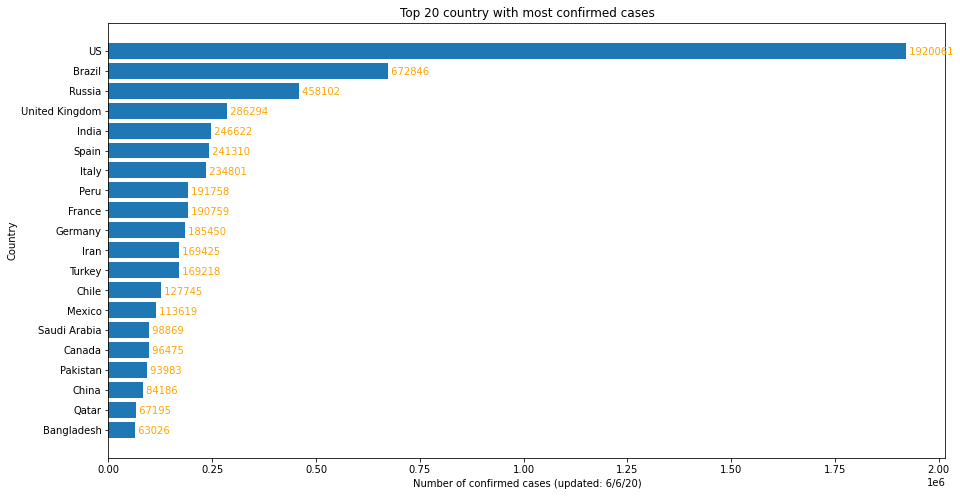

In [9]:
# Sum the amount of cases in different state group by country
df_confirmed_country = df_confirmed.groupby('Country/Region')[dates].sum().reset_index()
df_confirmed_country = df_confirmed_country.sort_values(by=df_confirmed_country.columns[-1], ascending=False)

# Plot the chart for top 20 most confirmed cases
plt.figure(figsize=(15,8))
plt.barh(df_confirmed_country[df_confirmed_country.columns[0]].iloc[:20][::-1], 
         df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title('Top 20 country with most confirmed cases')
plt.ylabel('Country')
plt.xlabel(f'Number of confirmed cases (updated: {df_confirmed_country.columns[-1]})')

Text(0.5, 0, 'Number of death cases (updated: 6/6/20)')

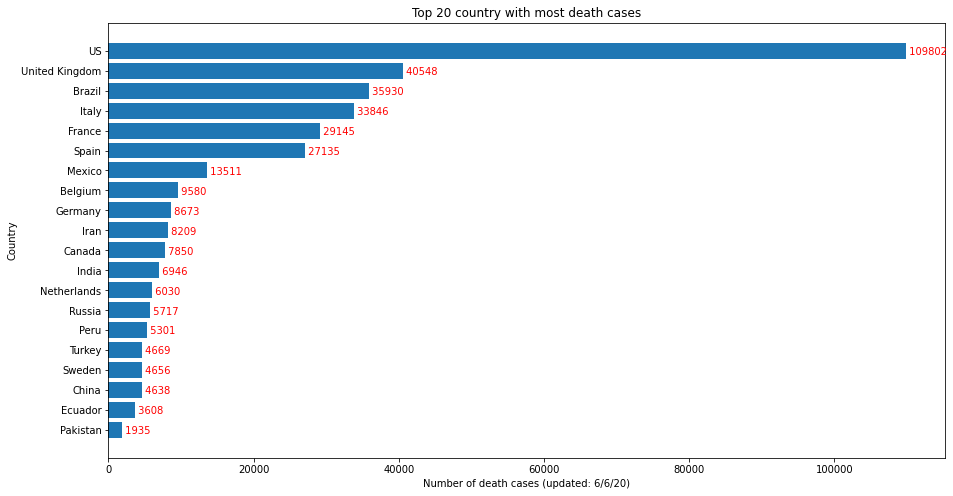

In [10]:
# Sum the amount of cases in different state group by country
df_death_country = df_death.groupby('Country/Region')[dates].sum().reset_index()
df_death_country = df_death_country.sort_values(by=df_death_country.columns[-1], ascending=False)

# Plot the chart for top 20 most death cases
plt.figure(figsize=(15,8))
plt.barh(df_death_country[df_death_country.columns[0]].iloc[:20][::-1], 
         df_death_country[df_death_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_country[df_death_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title('Top 20 country with most death cases')
plt.ylabel('Country')
plt.xlabel(f'Number of death cases (updated: {df_death_country.columns[-1]})')

Text(0.5, 0, 'Number of recovered cases (updated: 6/6/20)')

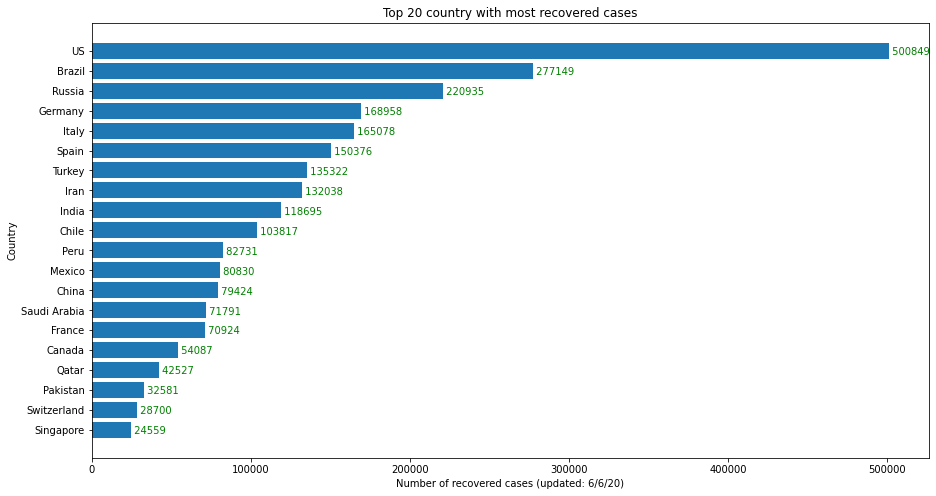

In [11]:
# Sum the amount of cases in different state group by country
df_recovered_country = df_recovered.groupby('Country/Region')[dates].sum().reset_index()
df_recovered_country = df_recovered_country.sort_values(by=df_recovered_country.columns[-1], ascending=False)

# Plot the chart for top 20 most recovered cases
plt.figure(figsize=(15,8))
plt.barh(df_recovered_country[df_recovered_country.columns[0]].iloc[:20][::-1], 
         df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title('Top 20 country with most recovered cases')
plt.ylabel('Country')
plt.xlabel(f'Number of recovered cases (updated: {df_recovered_country.columns[-1]})')

In [12]:
# Aggregate the latest number for confirmed, death and recovered cases for each country
df_agg = df_confirmed_country.iloc[:,[0,-1]].rename(columns={'Country/Region':'country',dates[-1]:'confirmed'})
df_agg = df_agg.join(df_death_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'death'})
df_agg = df_agg.join(df_recovered_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'recovered'})
df_agg.head(2)

,country,confirmed,death,recovered
174,US,1920061,109802,500849
23,Brazil,672846,35930,277149


In [13]:
# Calculate the current active cases and rate of death and recovered
df_agg['current_active'] = df_agg['confirmed'] - df_agg['death'] - df_agg['recovered']
df_agg['death_rate'] = round((df_agg['death'] / df_agg['confirmed']) * 100, 2)
df_agg['recovered_rate'] = round((df_agg['recovered'] / df_agg['confirmed']) * 100, 2)
df_agg.head(2)

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1920061,109802,500849,1309410,5.72,26.09
23,Brazil,672846,35930,277149,359767,5.34,41.19


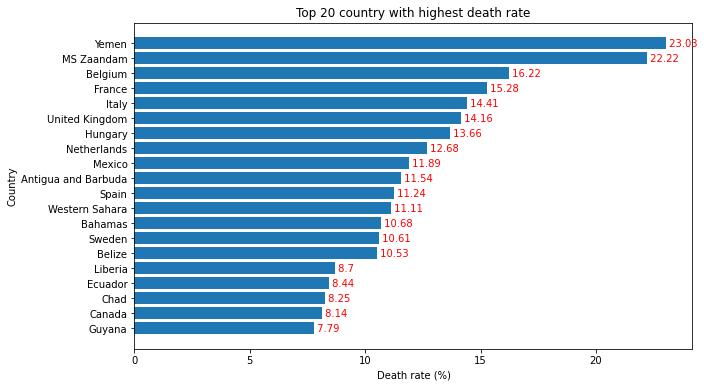

In [14]:
df_agg.sort_values(by='death_rate', inplace=True)

# Plot top 20 highest death rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['death_rate'].iloc[-20:])
plt.title("Top 20 country with highest death rate")
plt.xlabel("Death rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['death_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='red')

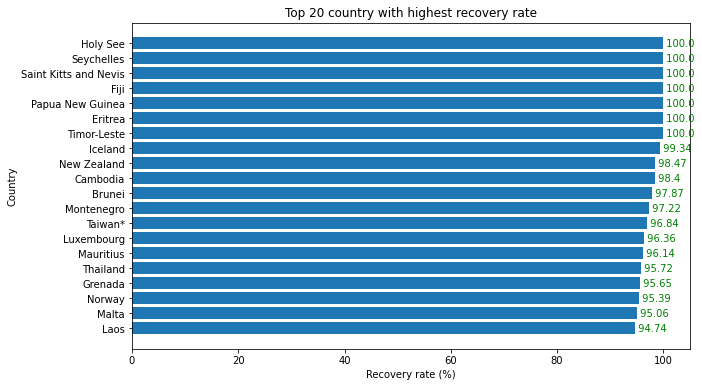

In [15]:
df_agg.sort_values(by='recovered_rate', inplace=True)

# Plot top 20 highest recovery rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['recovered_rate'].iloc[-20:])
plt.title("Top 20 country with highest recovery rate")
plt.xlabel("Recovery rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['recovered_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='green')

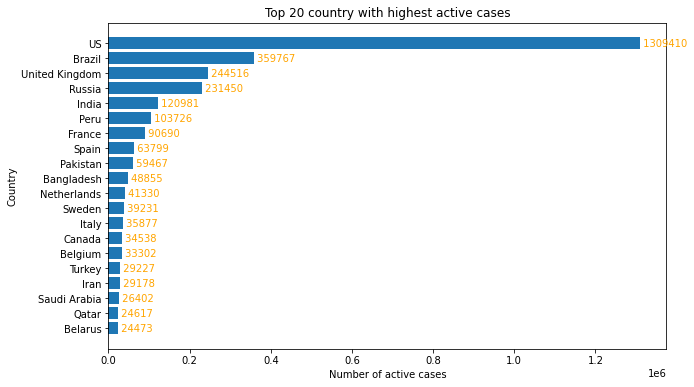

In [16]:
df_agg.sort_values(by='current_active', inplace=True)

# Plot top 20 highest active case
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['current_active'].iloc[-20:])
plt.title("Top 20 country with highest active cases")
plt.xlabel("Number of active cases")
plt.ylabel("Country")

for i, v in enumerate(df_agg['current_active'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='orange')

In [17]:
df_agg.sort_values(by='current_active', ascending=False, inplace=True)
df_agg.style.background_gradient(cmap='Reds')

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
174,US,1920061,109802,500849,1309410,5.720000,26.090000
23,Brazil,672846,35930,277149,359767,5.340000,41.190000
178,United Kingdom,286294,40548,1230,244516,14.160000,0.430000
140,Russia,458102,5717,220935,231450,1.250000,48.230000
79,India,246622,6946,118695,120981,2.820000,48.130000
134,Peru,191758,5301,82731,103726,2.760000,43.140000
62,France,190759,29145,70924,90690,15.280000,37.180000
158,Spain,241310,27135,150376,63799,11.240000,62.320000
130,Pakistan,93983,1935,32581,59467,2.060000,34.670000
13,Bangladesh,63026,846,13325,48855,1.340000,21.140000


### Malaysia Cases Analytic

In [0]:
# Extract Malaysia time series data
my_confirmed = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_recovered = df_recovered[df_recovered['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_death = df_death[df_death['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_active = my_confirmed - my_recovered - my_death

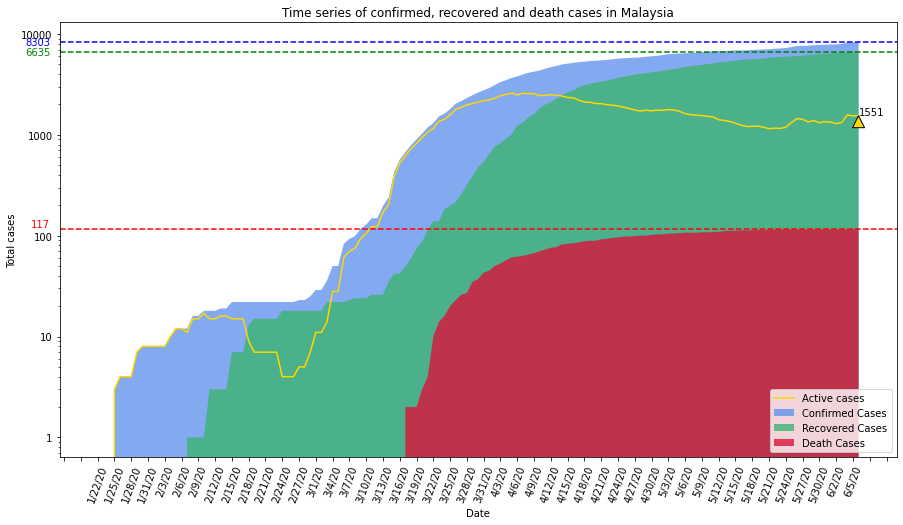

In [19]:
# Plot chart of cases in Malaysia
plt.figure(figsize=(15,8))

plt.fill_between(dates, my_confirmed, facecolor='cornflowerBlue', alpha=0.8, label='Confirmed Cases')
plt.fill_between(dates, my_recovered, facecolor='mediumSeaGreen', alpha=0.8, label='Recovered Cases')
plt.fill_between(dates, my_death, facecolor='crimson', alpha=0.8, label='Death Cases')
plt.plot(dates, my_active, color='gold', label='Active cases')

plt.axhline(y=my_confirmed[-1], color='blue', linestyle='--')
plt.axhline(y=my_recovered[-1], color='green', linestyle='--')
plt.axhline(y=my_death[-1], color='red', linestyle='--')
plt.text(int(len(dates)/-10), my_confirmed[-1], my_confirmed[-1], color='blue', va='center')
plt.text(int(len(dates)/-10), my_recovered[-1], my_recovered[-1], color='green', va='center')
plt.text(int(len(dates)/-11), my_death[-1] + 5, my_death[-1], color='red')
plt.annotate(s=my_active[-1], xy=(dates[-1], my_active[-1]), arrowprops=dict(facecolor='gold', shrink=0.05))

plt.yscale('log')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=70)
plt.title('Time series of confirmed, recovered and death cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.legend()

#### Predictive Model for Malaysia cases

In [0]:
# previous sequences used in LSTM
prev_day = 14

In [0]:
def lstm_model():
  keras.backend.clear_session()

  in_data = keras.Input((1),dtype='float32')

  X = keras.layers.Dense(128)(in_data)
  X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.Dense(128)(X)
  X = keras.layers.Dropout(0.2)(X)
  # X = keras.layers.LSTM(64)(X)
  # X = keras.layers.Dropout(0.2)(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(16, activation='relu')(X)
  X = keras.layers.Dense(1, activation='relu')(X)

  # Create Model instance which converts sentence_indices into X.
  model = keras.models.Model(inputs=in_data, outputs=X)
  print(model.summary())
  return model

In [88]:
model_confirmed = lstm_model()
model_confirmed.compile(optimizer='adam', loss='mean_squared_error')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               256       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528   

In [66]:
# Create training input for lstm
# sample_confirmed = np.pad(my_confirmed, (prev_day,0), 'constant', constant_values=0).reshape(my_confirmed.shape[0]+prev_day, 1)
# sample_confirmed = [sample_confirmed[i:i+prev_day]for i in range(0, len(sample_confirmed)-prev_day,1)]
# sample_confirmed = np.array(sample_confirmed).reshape(len(sample_confirmed),prev_day,1).astype(float)
# sample_recovered = np.pad(my_recovered, (prev_day,0), 'constant', constant_values=0).reshape(my_recovered.shape[0]+prev_day, 1)
# sample_recovered = [sample_recovered[i:i+prev_day]for i in range(0, len(sample_recovered)-prev_day,1)]
# sample_recovered = np.array(sample_recovered).reshape(len(sample_recovered),prev_day,1).astype(float)
# sample_death = np.pad(my_death, (prev_day,0), 'constant', constant_values=0).reshape(my_death.shape[0]+prev_day, 1)
# sample_death = [sample_death[i:i+prev_day]for i in range(0, len(sample_death)-prev_day,1)]
# sample_death = np.array(sample_death).reshape(len(sample_death),prev_day,1).astype(float)
# features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=2)

# Create training input for ff network
sample_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
sample_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
sample_death = np.array(my_death).reshape(len(my_death),1).astype(float)
features = np.concatenate((sample_confirmed, sample_recovered, sample_death), axis=1)

# Create label
label_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)
label_recovered = np.array(my_recovered).reshape(len(my_recovered),1).astype(float)
label_death = np.array(my_death).reshape(len(my_death),1).astype(float)
label = np.concatenate((label_confirmed, label_recovered, label_death), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = features[:-1]
y_train = label[1:]
# X_train, y_train = shuffle(X_train, y_train)
print(X_train.shape, y_train.shape)

(136, 3) (136, 3)


Epoch 100 -> loss: [105416.1171875] val_loss: [13500.3046875]
Epoch 200 -> loss: [93403.8828125] val_loss: [13135.4326171875]
Epoch 300 -> loss: [63077.5] val_loss: [99557.1875]
Epoch 400 -> loss: [61222.2265625] val_loss: [284145.3125]
Epoch 500 -> loss: [89387.0234375] val_loss: [188269.40625]
Epoch 600 -> loss: [66273.015625] val_loss: [122338.6640625]
Epoch 700 -> loss: [77949.84375] val_loss: [219649.78125]
Epoch 800 -> loss: [70358.90625] val_loss: [13967.4482421875]
Epoch 900 -> loss: [46995.6171875] val_loss: [77292.0546875]
Epoch 1000 -> loss: [58522.171875] val_loss: [774397.875]



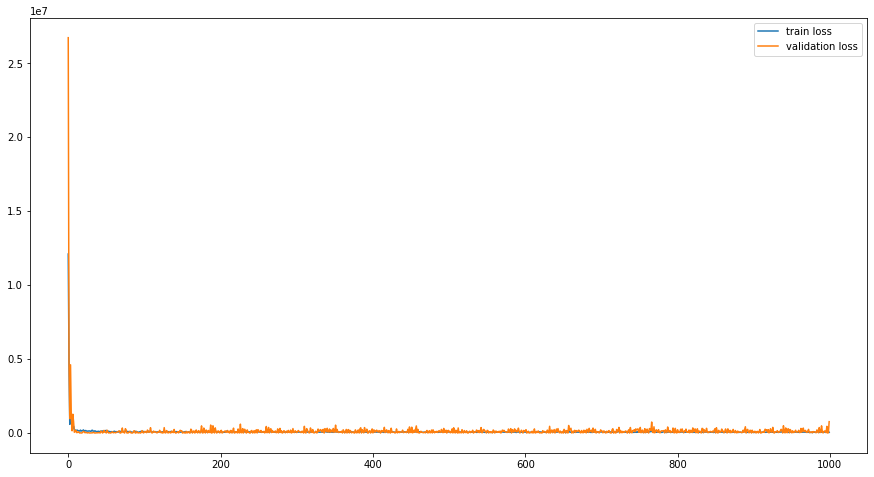

In [89]:
X_train_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)[:-1]
y_train_confirmed = np.array(my_confirmed).reshape(len(my_confirmed),1).astype(float)[1:]
epochs = 1000
batch_size = 32
model_hist = {
    'loss': [],
    'val_loss': []
}
for i in tqdm(range(epochs)):
  history = model_confirmed.fit(x=X_train_confirmed, y=y_train_confirmed, 
                      epochs=1, 
                      batch_size=batch_size, 
                      validation_split=0.1,
                      shuffle=True,
                      verbose=0)
  model_hist['loss'].append(history.history['loss'])
  model_hist['val_loss'].append(history.history['val_loss'])
  if((int((i+1)%(epochs/10)) == 0) or (i == (epochs-1))):
    print(f"Epoch {i+1} -> loss: {history.history['loss']} val_loss: {history.history['val_loss']}")

# Plot model traning loss
plt.figure(figsize=(15,8))
plt.plot(model_hist['loss'], label='train loss')
plt.plot(model_hist['val_loss'], label='validation loss')
plt.legend()

In [96]:
y_pred = model.predict(X_train_confirmed)

ValueError: ignored

In [0]:
# Forecasting day
forecast_days = 30

# pred_feature = features[-1:]
# pred_feature = np.concatenate((pred_feature[:,1:,:], y_pred[-1].reshape((1,1,3))),axis=1)
pred_feature = y_pred[-1:]
pred_date = dates


for day in range(forecast_days):
    pred = model.predict(pred_feature)
    y_pred = np.concatenate((y_pred, pred), axis=0)
    pred_date = pred_date + [(datetime.strptime(pred_date[-1], '%x') + timedelta(days=1)).strftime("%x")]
    # pred_feature = np.concatenate((pred_feature[:,1:,:], pred.reshape((1,1,3))),axis=1) 
    pred_feature = y_pred[-1:]
    

In [95]:
len(pred_date)

167

ValueError: ignored

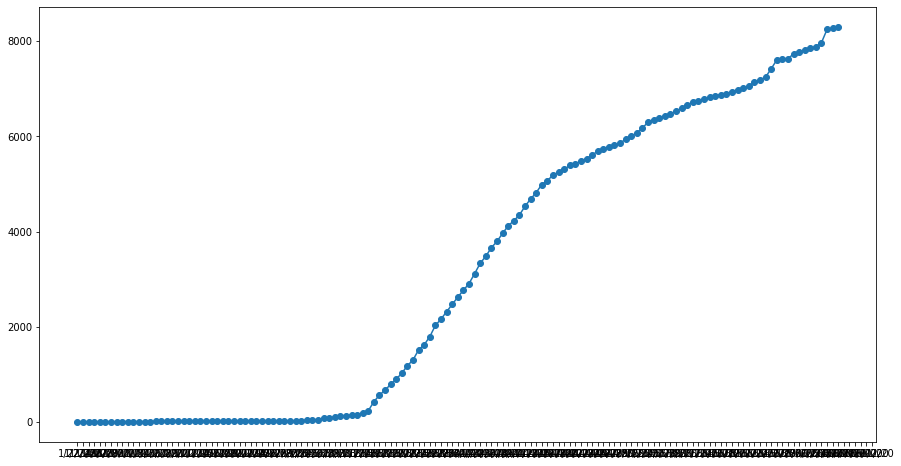

In [92]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_confirmed, marker='o', label='actual cases')
plt.plot(pred_date[:-1], y_pred[:,0], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Confirmed)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

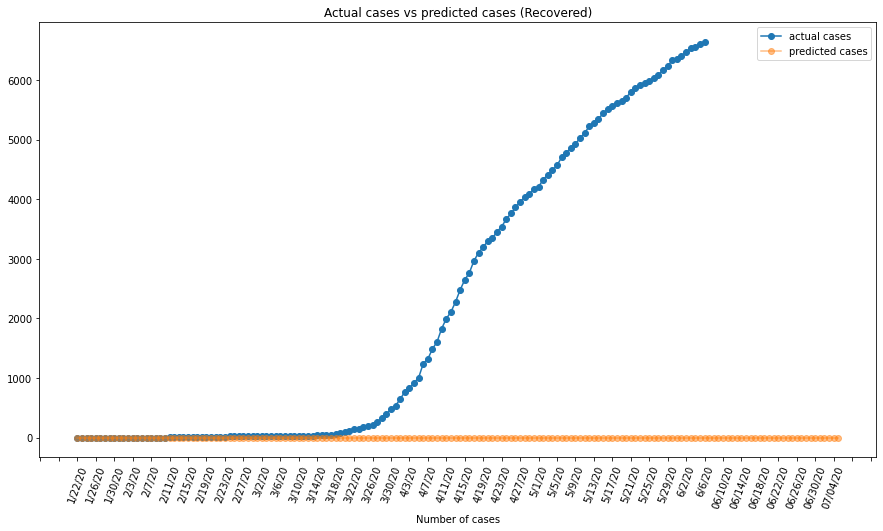

In [74]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_recovered, marker='o', label='actual cases')
plt.plot(pred_date[:-1], y_pred[:,1], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Recovered)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

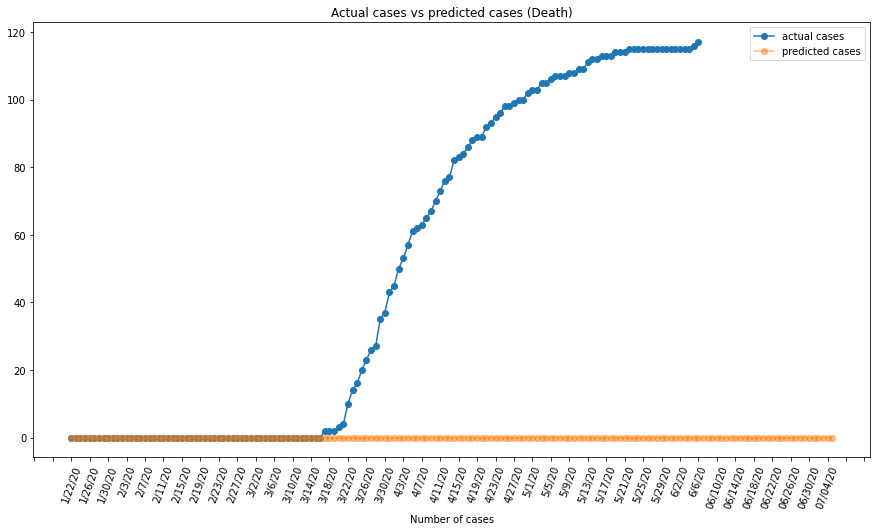

In [75]:
plt.figure(figsize=(15,8))
plt.plot(dates, my_death, marker='o', label='actual cases')
plt.plot(pred_date[:-1], y_pred[:,2], marker='o', label='predicted cases', alpha=0.5)
plt.title("Actual cases vs predicted cases (Death)")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()